In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import time
import unittest
import scipy.io

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation from scratch

## Definition of aditional functions 

### Compute mean and std for the dataset 

In [6]:
def compute_mean_std(dataset, batch_size=512, num_workers=4, pin_memory=True):
    """
    Compute the per-channel mean and std of an image dataset.

    Args:
        dataset (torch.utils.data.Dataset):
            A PyTorch Dataset whose __getitem__ returns either:
              - image Tensor of shape (C, H, W), or
              - (image Tensor, label) tuple.
            IMPORTANT: dataset.transforms must include only ToTensor()
                       (i.e. no Normalize), so images are in [0,1].
        batch_size (int): how many images to load per batch.
        num_workers (int): DataLoader num_workers for parallel loading.
        pin_memory (bool): whether to use pin_memory in DataLoader.

    Returns:
        mean (torch.Tensor): shape (3,) tensor of channel means.
        std  (torch.Tensor): shape (3,) tensor of channel stds.
    """
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    # We'll accumulate sum(pixel) and sum(pixel^2) over all images:
    n_channels = 3
    total_pixels = 0  # total number of pixels per channel
    sum_   = torch.zeros(n_channels)
    sum_sq = torch.zeros(n_channels)

    for batch in loader:
        # batch may be (images, labels) or just images
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        # images: (B, C, H, W)
        B, C, H, W = images.shape

        # flatten each image to (B, C, H*W)
        imgs = images.view(B, C, -1)

        # update pixel count
        total_pixels += B * H * W

        # sum over batch & pixels
        sum_   += imgs.sum(dim=[0, 2])
        sum_sq += (imgs * imgs).sum(dim=[0, 2])

    # mean = E[x]
    mean = sum_ / total_pixels

    # std = sqrt(E[x^2] - E[x]^2)
    std = torch.sqrt(sum_sq / total_pixels - mean**2)

    return mean, std

## Preprocessing

### Computing of mean and std

In [7]:
raw_transform = transforms.Compose([
    transforms.ToTensor()  # scale [0,255] → [0,1], channel-first
])
## here we force the dataset to be in [0,1] range to compute mean and std
raw_train_ds = datasets.SVHN(root='./data', split='train', download=True,
                             transform=raw_transform)

100%|██████████| 182M/182M [02:31<00:00, 1.20MB/s]  


In [8]:
train_size = int(0.8 * len(raw_train_ds))   # e.g., ~58k
val_size   = len(raw_train_ds) - train_size # ~15k
train_ds, val_ds = random_split(raw_train_ds, [train_size, val_size])

In [9]:
mean, std = compute_mean_std(raw_train_ds,
                             batch_size=512,
                             num_workers=4,
                             pin_memory=True)
print("Computed SVHN mean:", mean.tolist())
print("Computed SVHN std: ", std.tolist())

Computed SVHN mean: [0.4376820921897888, 0.4437696635723114, 0.47280436754226685]
Computed SVHN std:  [0.1980302929878235, 0.20101578533649445, 0.19703631103038788]


### Transforms 

In [ ]:
train_transform = transforms.Compose([
    # 1. Padding + random crop simulates shifts
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # simulate left-right variation
    transforms.RandomRotation(10),  
    # Color jitter for brightness/contrast/saturation
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),                          # scale [0,255]→[0,1], and (H,W,C)→(C,H,W)
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

### Datasets with full transforms 

In [12]:
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = test_transform
test_ds  = datasets.SVHN(root='./data', split='test',  download=True,
                        transform=test_transform)

100%|██████████| 64.3M/64.3M [00:38<00:00, 1.66MB/s]


### Dataloaders

In [13]:
batch_size = 128
num_workers = 4   # use multiple CPU cores
pin_memory  = True  # faster GPU transfers

train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=pin_memory)

val_loader   = DataLoader(val_ds,
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)

test_loader = DataLoader(test_ds,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=pin_memory)


### Cnn architecture from scratch 

In [25]:
class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()
        # Block 1: Conv → ReLU → Conv → ReLU → Pool → BatchNorm
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
            
        )
        # Block 2: deeper features
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
        )
        # Block 3 (added capacity)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2)
        )
        # Global average pool → tiny head
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),            # (B,128)
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        # Block 1
        x = self.block1(x) # 32×32 → 16×16
        # Block 2
        x = self.block2(x) # 16×16 → 8×8
        # Block 3
        x = self.block3(x)    # 8×8 → 4×4
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

### Loss & optimizer 

In [26]:
model  = ScratchCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  
optimizer = optim.Adam(    
                       model.parameters(),
    lr=1e-3,
    weight_decay=1e-4     # <— adds L2 regularization
    )

### Training and test loops

In [27]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)              
        loss = criterion(outputs, labels)
        loss.backward()                   
        optimizer.step()                 

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [28]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    return running_loss / total, correct / total

In [29]:
num_epochs = 20
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss,   val_acc   = validate(model,   val_loader,   criterion, DEVICE)
    elapsed = time.time() - start

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_scratch_cnn.pth')

    print(f"Epoch {epoch:02d}  "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}  "
          f"time={elapsed:.1f}s")


Epoch 01  Train: loss=1.5210, acc=0.5683  Val:   loss=0.8347, acc=0.8893  time=7.8s
Epoch 02  Train: loss=0.8823, acc=0.8866  Val:   loss=0.7312, acc=0.9244  time=6.5s
Epoch 03  Train: loss=0.7979, acc=0.9177  Val:   loss=0.6965, acc=0.9331  time=6.4s
Epoch 04  Train: loss=0.7647, acc=0.9301  Val:   loss=0.6816, acc=0.9372  time=9.3s
Epoch 05  Train: loss=0.7387, acc=0.9384  Val:   loss=0.6679, acc=0.9429  time=6.5s
Epoch 06  Train: loss=0.7227, acc=0.9438  Val:   loss=0.6735, acc=0.9412  time=5.9s
Epoch 07  Train: loss=0.7114, acc=0.9489  Val:   loss=0.6583, acc=0.9453  time=6.5s
Epoch 08  Train: loss=0.7013, acc=0.9525  Val:   loss=0.6592, acc=0.9454  time=6.3s
Epoch 09  Train: loss=0.6916, acc=0.9560  Val:   loss=0.6587, acc=0.9451  time=8.6s
Epoch 10  Train: loss=0.6838, acc=0.9587  Val:   loss=0.6581, acc=0.9438  time=6.0s
Epoch 11  Train: loss=0.6776, acc=0.9611  Val:   loss=0.6549, acc=0.9449  time=5.8s
Epoch 12  Train: loss=0.6739, acc=0.9626  Val:   loss=0.6567, acc=0.9459  ti

In [30]:
# Load best weights
model.load_state_dict(torch.load('best_scratch_cnn.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, DEVICE)
print(f"Test accuracy: {test_acc:.4f} "
      f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9563 Test loss: 0.6344


### more metrics

<Axes: >

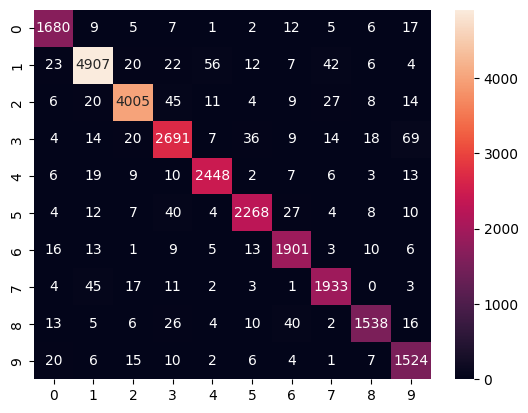

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")


# Implementation with Pre-trained model